In [75]:
# importation des biblio necessaire 
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
from collections import Counter


In [76]:
# les chemins et les fichiers XML à traiter
xml_files = [
    'Restaurants_Train.xml',
    'Laptop_Train.xml',
    'Restaurants_Test_Gold.xml',
    'Laptop_Test_Gold.xml'
]
folder_path = '../data'


In [77]:
#fonctionpour traiter les fichier xml
def process_xml_file(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    data = []
    for sentence in root.findall('.//sentence'):
        sentence_id = sentence.get('id')
        text = sentence.find('text').text
        aspect_terms = []
        aspect_categories = []
        for aspectTerm in sentence.findall('.//aspectTerms/aspectTerm'):
            term = aspectTerm.get('term')
            polarity = aspectTerm.get('polarity')
            from_idx = aspectTerm.get('from')
            to_idx = aspectTerm.get('to')
            aspect_terms.append((term, polarity, from_idx, to_idx))
        for aspectCategory in sentence.findall('.//aspectCategories/aspectCategory'):
            category = aspectCategory.get('category')
            polarity = aspectCategory.get('polarity')
            aspect_categories.append((category, polarity))
        data.append({
            'sentence_id': sentence_id,
            'text': text,
            'aspect_terms': aspect_terms,
            'aspect_categories': aspect_categories
        })
    return data


In [78]:
#traitement de chaque fichier et stockage des données 
all_data = {}
for file_name in xml_files:
    file_path = os.path.join(folder_path, file_name)
    all_data[file_name] = process_xml_file(file_path)


In [79]:
# Analyse et affichage des informations sur les données
aspect_terms_counter = Counter()
aspect_categories_counter = Counter()
for file_name, data in all_data.items():
    for entry in data:
        for term in entry['aspect_terms']:
            aspect_terms_counter[term[0]] += 1
        for category in entry['aspect_categories']:
            aspect_categories_counter[category[0]] += 1

print("Termes d'aspect les plus communs :", aspect_terms_counter.most_common(10))
print("Catégories d'aspect les plus communes :", aspect_categories_counter.most_common(10))


Termes d'aspect les plus communs : [('food', 373), ('service', 220), ('price', 101), ('place', 66), ('prices', 65), ('staff', 60), ('screen', 60), ('menu', 58), ('dinner', 57), ('battery life', 55)]
Catégories d'aspect les plus communes : [('food', 1273), ('anecdotes/miscellaneous', 1178), ('service', 605), ('ambience', 438), ('price', 333)]


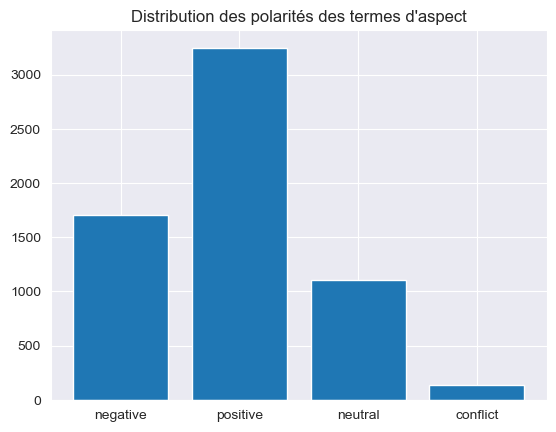

In [80]:
#  Visualisation de la distribution des polarités
polarity_counter = Counter()
for file_name, data in all_data.items():
    for entry in data:
        for term in entry['aspect_terms']:
            polarity_counter[term[1]] += 1

plt.bar(polarity_counter.keys(), polarity_counter.values())
plt.title('Distribution des polarités des termes d\'aspect')
plt.show()


In [81]:
import spacy
nlp = spacy.load("en_core_web_sm")


def load_sentiwordnet(swn_path):
    swn_scores = {}
    with open(swn_path, 'r') as csvfile:
        for line in csvfile:
            if line.startswith('#') or not line.strip():
                continue
            fields = line.split('\t')
            if len(fields) >= 6:
                pos, id, pos_score, neg_score, synset_terms, gloss = fields[:6]
                pos_score = float(pos_score) if pos_score else 0.0
                neg_score = float(neg_score) if neg_score else 0.0
                for term_compound in synset_terms.split():
                    term = term_compound.split('#')[0]
                    key = f'{term}.{pos}'
                    swn_scores[key] = (pos_score, neg_score)
    return swn_scores

swn_path = '../data/SentiWordNet_3.0.0.txt'
swn_scores = load_sentiwordnet(swn_path)

In [82]:
def get_wordnet_pos(spacy_token):
    """Convertir les tags POS de spaCy en tags de WordNet."""
    if spacy_token.pos_ == 'ADJ':
        return 'a'
    elif spacy_token.pos_ == 'VERB':
        return 'v'
    elif spacy_token.pos_ == 'NOUN':
        return 'n'
    elif spacy_token.pos_ == 'ADV':
        return 'r'
    return None

def process_xml_file(file_path, swn_scores):
    tree = ET.parse(file_path)
    root = tree.getroot()
    data = []
    for sentence in root.findall('.//sentence'):
        sentence_id = sentence.get('id')
        text = sentence.find('text').text
        doc = nlp(text)
        
        tokens_with_polarity = []
        for token in doc:
            wn_pos = get_wordnet_pos(token)
            key = f"{token.lemma_}.{wn_pos}"
            scores = swn_scores.get(key, [])
            pos_score = sum(score[0] for score in scores)
            neg_score = sum(score[1] for score in scores)
            polarity = 'positive' if pos_score > neg_score else 'negative' if neg_score > pos_score else 'neutral'
            tokens_with_polarity.append((token.text, polarity))
        
        data.append({
            'sentence_id': sentence_id,
            'text': text,
            'tokens_with_polarity': tokens_with_polarity
        })
    return data


In [83]:


def analyze_aspect_based_polarity(all_data):
    for file_name, entries in all_data.items():
        print(f"Analyzing {file_name}")
        for entry in entries:
            if 'aspect_terms' in entry:
                for term, polarity, from_idx, to_idx in entry['aspect_terms']:
                    print(f"Sentence ID: {entry['sentence_id']}, Term: {term}, Polarity: {polarity}")

analyze_aspect_based_polarity(all_data)


Analyzing Restaurants_Train.xml
Sentence ID: 3121, Term: staff, Polarity: negative
Sentence ID: 2777, Term: food, Polarity: positive
Sentence ID: 1634, Term: food, Polarity: positive
Sentence ID: 1634, Term: kitchen, Polarity: positive
Sentence ID: 1634, Term: menu, Polarity: neutral
Sentence ID: 2846, Term: food, Polarity: positive
Sentence ID: 2846, Term: perks, Polarity: positive
Sentence ID: 1458, Term: orrechiete with sausage and chicken, Polarity: positive
Sentence ID: 1458, Term: waiters, Polarity: positive
Sentence ID: 1458, Term: meats, Polarity: neutral
Sentence ID: 1458, Term: dish, Polarity: neutral
Sentence ID: 3161, Term: Bagels, Polarity: positive
Sentence ID: 2391, Term: food, Polarity: positive
Sentence ID: 296, Term: toast, Polarity: negative
Sentence ID: 296, Term: mayonnaise, Polarity: negative
Sentence ID: 296, Term: bacon, Polarity: negative
Sentence ID: 296, Term: cheese, Polarity: neutral
Sentence ID: 296, Term: ingredients, Polarity: negative
Sentence ID: 296, 

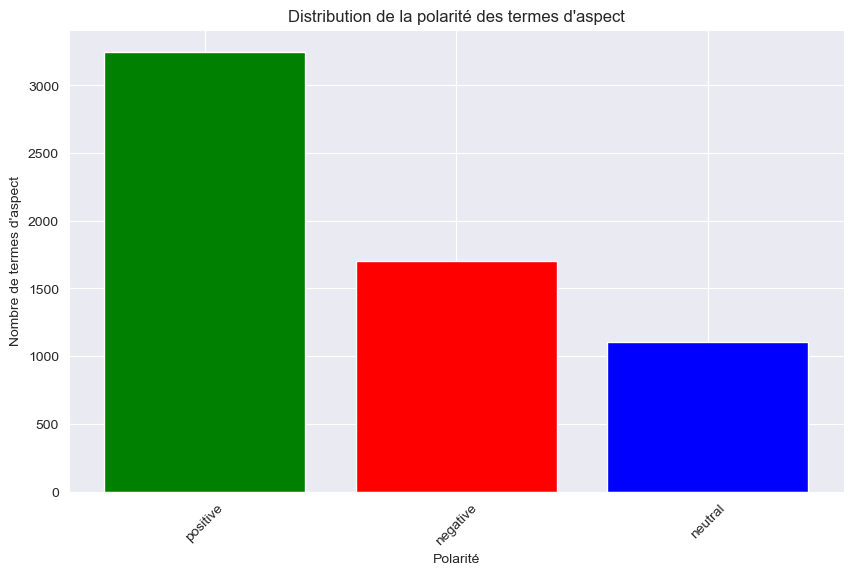

In [84]:
import matplotlib.pyplot as plt

# Préparer les données pour la visualisation
aspect_polarity_counts = {'positive': 0, 'negative': 0, 'neutral': 0}
for file_name, entries in all_data.items():
    for entry in entries:
        if 'aspect_terms' in entry:
            for term, polarity, from_idx, to_idx in entry['aspect_terms']:
                if polarity in aspect_polarity_counts:
                    aspect_polarity_counts[polarity] += 1

# Créer une figure pour la visualisation
plt.figure(figsize=(10, 6))

# Noms des polarités
polarities = list(aspect_polarity_counts.keys())
# Comptes pour chaque polarité
counts = [aspect_polarity_counts[polarity] for polarity in polarities]

# Créer le diagramme à barres
plt.bar(polarities, counts, color=['green', 'red', 'blue'])

# Ajouter des titres et étiquettes
plt.title('Distribution de la polarité des termes d\'aspect')
plt.xlabel('Polarité')
plt.ylabel('Nombre de termes d\'aspect')
plt.xticks(rotation=45)

# Afficher la visualisation
plt.show()


In [63]:
# Préparation des données de polarité
polarity_counts = {file_name: {'positive': 0, 'negative': 0, 'neutral': 0, 'unknown': 0} for file_name in xml_files}

for file_name, entries in all_data.items():
    for entry in entries:
        if 'aspect_terms' in entry:
            for term, polarity, from_idx, to_idx in entry['aspect_terms']:
                if polarity in polarity_counts[file_name]:
                    polarity_counts[file_name][polarity] += 1
                else:
                    polarity_counts[file_name]['unknown'] += 1


C:\Users\chalh\AppData\Local\Temp\ipykernel_18248\3704373950.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


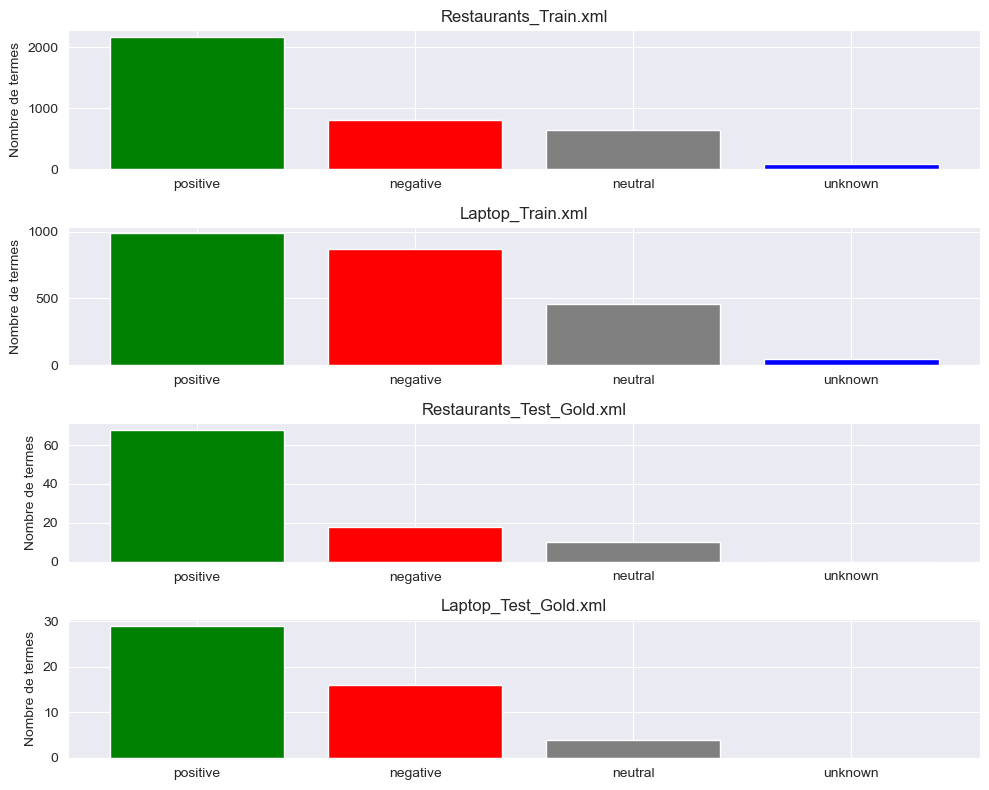

In [64]:
import matplotlib.pyplot as plt

# Configuration de la taille du graphique
plt.figure(figsize=(10, 8))

# Création de graphiques en barres pour chaque fichier
n_files = len(xml_files)
for i, (file_name, counts) in enumerate(polarity_counts.items(), 1):
    plt.subplot(n_files, 1, i)
    plt.bar(counts.keys(), counts.values(), color=['green', 'red', 'grey', 'blue'])
    plt.title(file_name)
    plt.ylabel('Nombre de termes')
    plt.tight_layout()

plt.show()
